/Users/abhishekgupta/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


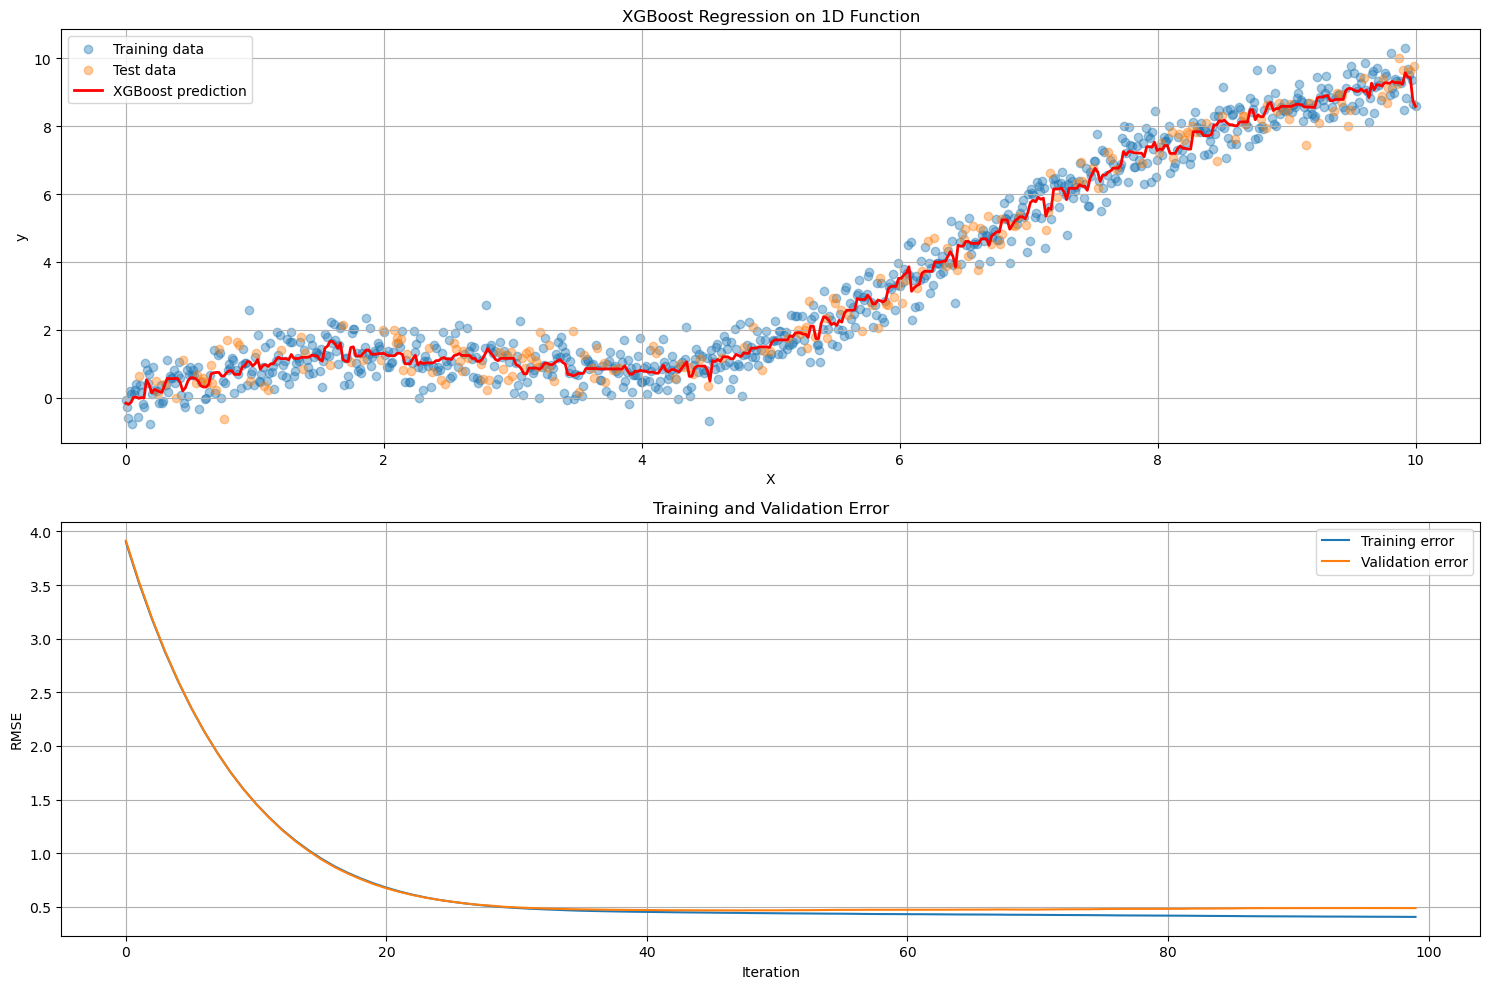

Training RMSE: 0.4067
Test RMSE: 0.4885
Feature importance: [1.]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from typing import Tuple, List, Any


def generate_data(
    n_samples: int = 1000, 
    noise_level: float = 0.5
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic 1D data with noise.
    
    Args:
        n_samples: Number of data points to generate
        noise_level: Standard deviation of Gaussian noise
        
    Returns:
        Tuple of (X, y) arrays where X is the input and y is the target
    """
    # Generate evenly spaced points in [0, 10]
    X = np.linspace(0, 10, n_samples).reshape(-1, 1)
    
    # Create a non-linear function: y = sin(x) + 0.1*x^2 + noise
    y = np.sin(X.ravel()) + 0.1 * X.ravel()**2 + noise_level * np.random.randn(n_samples)
    
    return X, y


def train_xgboost_model(
    X: np.ndarray, 
    y: np.ndarray, 
    test_size: float = 0.2
) -> Tuple[xgb.XGBRegressor, List[float], List[float], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Train an XGBoost model on the provided data.
    
    Args:
        X: Input features
        y: Target values
        test_size: Proportion of data to use for testing
        
    Returns:
        Tuple containing:
        - Trained model
        - Training error history
        - Validation error history
        - X_train, X_test, y_train, y_test data splits
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Define XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 4,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }
    
    # Create and train the model
    model = xgb.XGBRegressor(**params)
    
    # Use eval_set to track training and validation errors
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        eval_metric='rmse',
        verbose=False
    )
    
    # Get the error history
    results = model.evals_result()
    train_errors = results['validation_0']['rmse']
    val_errors = results['validation_1']['rmse']
    
    return model, train_errors, val_errors, X_train, X_test, y_train, y_test


def visualize_results(
    model: xgb.XGBRegressor,
    X: np.ndarray,
    y: np.ndarray,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    train_errors: List[float],
    val_errors: List[float]
) -> None:
    """
    Visualize the model predictions and error curves.
    
    Args:
        model: Trained XGBoost model
        X: Complete input data
        y: Complete target data
        X_train, X_test, y_train, y_test: Train/test data splits
        train_errors: List of training errors
        val_errors: List of validation errors
    """
    # Create a fine grid for smooth predictions
    X_grid = np.linspace(0, 10, 500).reshape(-1, 1)
    y_pred = model.predict(X_grid)
    
    # Plot actual function vs. prediction
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.scatter(X_train, y_train, alpha=0.4, label='Training data')
    plt.scatter(X_test, y_test, alpha=0.4, label='Test data')
    plt.plot(X_grid, y_pred, 'r-', label='XGBoost prediction', linewidth=2)
    plt.title('XGBoost Regression on 1D Function')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    # Plot error curves
    plt.subplot(2, 1, 2)
    plt.plot(train_errors, label='Training error')
    plt.plot(val_errors, label='Validation error')
    plt.title('Training and Validation Error')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print model performance
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")


def main() -> None:
    """Main function to run the program."""
    # Generate data
    X, y = generate_data(n_samples=1000, noise_level=0.5)
    
    # Train the model
    model, train_errors, val_errors, X_train, X_test, y_train, y_test = train_xgboost_model(X, y)
    
    # Visualize results
    visualize_results(model, X, y, X_train, X_test, y_train, y_test, train_errors, val_errors)
    
    # Feature importance
    importance = model.feature_importances_
    print(f"Feature importance: {importance}")


if __name__ == "__main__":
    main()